# NATS simulation and result visualization using <code>para-atm</code>

This notebook demonstrates the process of running a generic NATS simulation for an existing set of TRX and MFL files using <code>para-atm</code>. This notebook is general and can be repurposed for any NATS input.

Some specific notes and requirements to consider when running the following code:
<ul>
    <li>The NATS input TRX and MFL files used could be generated from <code>nats-fpgen.ipynb</code> which can be found <a href=http://localhost:8888/notebooks/nats-fpgen.ipynb>here</a>. This will will create a NATS input file from a user-defined IFF file.</li>
    <li>Required packages: <code>os</code>, <code>time</code>, <code>jpype</code>, and <code>para-atm</code> which can be cloned from the <a href="https://github.com/ymlasu/para-atm">para-atm</a> respository. </li> 
    <li>In addition, setup of NATS and the <code>NATS_HOME</code> variable is required. Testing in <code>para-atm</code> is available for verifying the NATS setup and compatibility with <code>para-atm</code>.</li>
</ul>

## Step 1: Specify NATS input TRX and MFL files

First provide the location of the existing TRX and MFL files to be input in the NATS simulation. Here, the example files are in the "Current Working Directory (CWD)" and so the <code>os</code> package retrieves the current working directory to find the input files and write the NATS output.

The name of the TRX and MFL files used in this example are <code>iff_to_gnats_geo.trx</code> and <code>iff_to_gnats_geo_mfl.trx</code>, respectively. These two input files were generated using <code>nats-fpgen.ipynb</code> which is co-located in this repository. The NATS output file will be <code>iff_to_gnats_geo.csv</code>.


In [1]:
import os
trx_dir = os.getcwd()
results_dir = os.getcwd()

trx_fname = '/iff_to_gnats_geo_SFO_depOnly'
mfl_file= trx_dir+trx_fname+'_mfl.trx'
trx_file = trx_dir+trx_fname+'.trx'
coord_file = trx_dir+trx_fname+'.crd'

results_file = results_dir+trx_fname+'.csv'

## Step 2: Run NATS simulation

Next, import the <code>GateToGate</code> simulation class from the local <code>gnats_gate_to_gate.py</code> file which is modified from the test script found in the <code>para-atm</code> Python package. The modifications were such so that the only inputs to a simulation instance is the TRX and MFL files. The results are written to a csv file at the requested location.

In [2]:
from gnats_gate_to_gate import GateToGate

natsSim = GateToGate()
data=natsSim(trx_name=trx_file,mfl_name=mfl_file)['trajectory']
natsSim.write_output(results_file)

SFOlat,SFOlon = list(natsSim.airportInterface.getLocation('KSFO'))

natsSim.cleanup()

### Step 3: Shift simulation timestamps to be consistent with iff data


In [3]:
import pandas as pd

with open(coord_file, 'r') as rFile:
    rLines = rFile.readlines()
    
trxCallsigns = [line.split(' ')[0] for line in rLines]
trxTracktimes = [int(line.split(' ')[1]) for line in rLines]
trxLandingTimes = [int(line.split(' ')[4]) for line in rLines]
trxLandingLatitudes = [float(line.split(' ')[5]) for line in rLines]
trxLandingLongitudes = [float(line.split(' ')[6]) for line in rLines]

trxTimestamps = [pd.Timestamp("1970-01-01") + pd.Timedelta(seconds=tracktime) for tracktime in trxTracktimes]
trxLandingTimestamps = [pd.Timestamp("1970-01-01") + pd.Timedelta(seconds=tracktime) for tracktime in trxLandingTimes]

In [4]:
import numpy as np
import pandas as pd

dfSim = data[['time','latitude','longitude','heading','callsign','altitude']]

for no, cs in enumerate(trxCallsigns):
    
    df = dfSim.loc[dfSim['callsign']==cs]
                                                                                              
    trxLat, trxLon, trxTracktime = trxLandingLatitudes[no], trxLandingLongitudes[no], trxLandingTimes[no] 
    simTimes = df['time']
    
    minDist, tStart = None, 0
    for tIncr, tVal in enumerate(simTimes):

        simLat, simLon = df['latitude'].iloc[tIncr], df['longitude'].iloc[tIncr]

        tDist = np.sqrt((trxLat-simLat)**2+(trxLon-simLon)**2)
        tDir = (trxLat-simLat)*(SFOlat-simLat)+ (trxLon-simLon)*(SFOlon-simLon)
        
        minDist= tDist if minDist is None else minDist          
        if tDist < minDist: minDist, tStart = tDist, tVal
    
    tStartSecs =(tStart-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')    
    tOffset = trxTracktime - tStartSecs
 
    for tIncr, tVal in enumerate(simTimes):
        dfSim.loc[(dfSim['callsign']==cs) & (dfSim['time']==tVal), ['time']] = tVal +  pd.Timedelta(seconds=tOffset)
   

/home/edecarlo/anaconda3/envs/paraatm/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/edecarlo/anaconda3/envs/paraatm/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/edecarlo/anaconda3/envs/paraatm/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying t

## Step 4: Plot NATS simulation results

Upon successful execution of the simulation, use the <code>plot_trajectory</code> function within the <code>para-atm.plotting</code> library to plot the resulting flight plan trajectories from NATS. 

In this example, the results contain four detailed trajectories capturing ground operations (three departures and one arrival) around SFO. The focus here is to replicate aircraft landing and taking off at SFO.

In [5]:
from paraatm.plotting import plot_trajectory

plotTimeframe = 800

plotStart = pd.Timestamp("1970-01-01") + pd.Timedelta(seconds=trxTracktimes[0])
plotEnd = plotStart + pd.Timedelta(seconds=plotTimeframe)

dfPlot = dfSim.loc[dfSim['time']>=plotStart]

plot_trajectory(dfPlot, output_notebook=True, plot_width=600, plot_height=400)

Loading BokehJS ...

## Step 5: Compare NATS simulation results to IFF data
Likewise, the the <code>plot_trajectory</code> function within the <code>para-atm.plotting</code> library can plot IFF data (recType=3) as well.

First, because NATS changes the working directory behind the scenes, we must use the <code>os</code> package to navigate back to the directory with the IFF files. Then, we can plot the IFF data and study the simulation with the NATS simulation results.

In [6]:
import os
from paraatm.io.iff import read_iff_file

# get flight call data within speficied timeframe
minTime, maxTime = dfPlot['time'].min(), dfPlot['time'].max()

# plot iff data for selected flights
home=os.getenv('HOME')
iff_dir = home+'/para-atm-collection/miscellaneous/gnats-fpgen/'
iff_fname = iff_dir+'IFF_SFO+ASDEX_20190511_080104_86221.csv'

iff_data =  read_iff_file(iff_fname,record_types=[2,3,4,8])

plot_data = iff_data[3].loc[iff_data[3]['callsign'].isin(trxCallsigns)]
plot_data = plot_data.loc[(plot_data['time']<=maxTime) & (plot_data['time']>=minTime)]

plot_trajectory(plot_data, output_notebook=True, plot_width=600, plot_height=400)

FileNotFoundError: [Errno 2] No such file or directory: '/home/edecarlo/para-atm-collection/miscellaneous/gnats-fpgen/IFF_SFO+ASDEX_20190511_080104_86221.csv'

NameError: name 'plot_data' is not defined

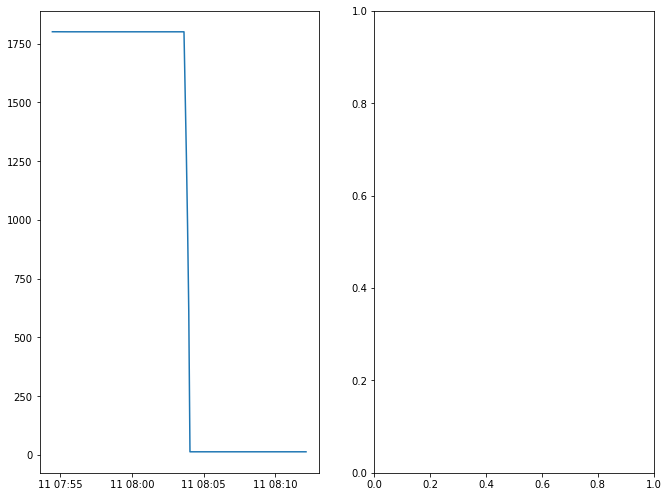

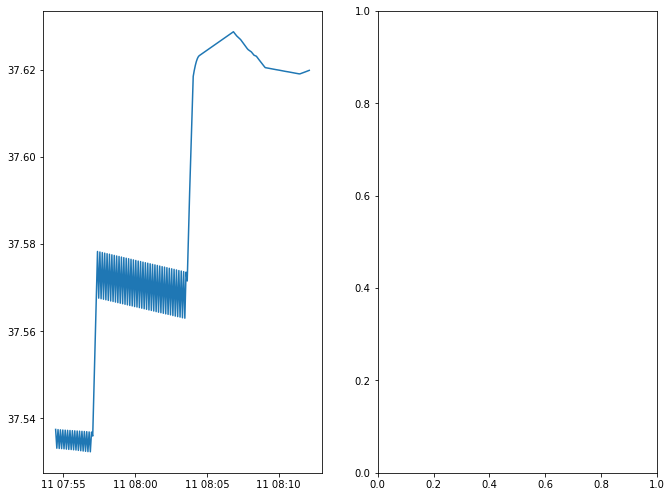

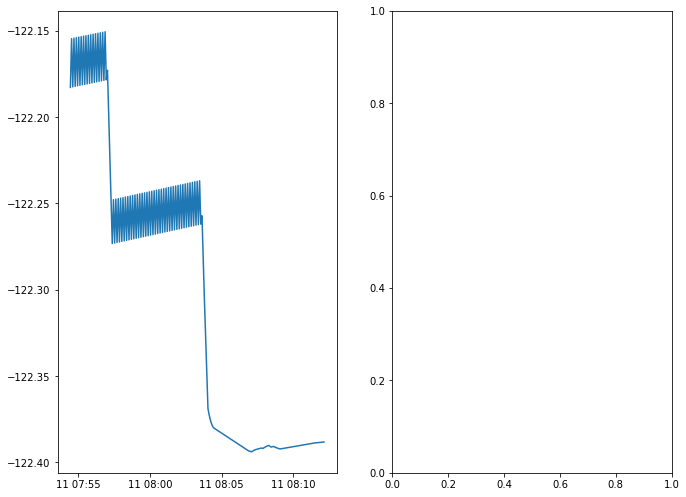

In [7]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime

ALTfig, (ALTaxs, ALTaxsIFF) = plt.subplots(1,2)
ALTfig.set_size_inches(11.0,8.5)

LATfig, (LATaxs, LATaxsIFF) = plt.subplots(1,2)
LATfig.set_size_inches(11.0,8.5)

LONfig, (LONaxs, LONaxsIFF) = plt.subplots(1,2)
LONfig.set_size_inches(11.0,8.5)

minTime, maxTime = dfPlot['time'].min(), dfPlot['time'].max()
minAltitude, maxAltitude = dfPlot['altitude'].min(), dfPlot['altitude'].max()
minLatitude, maxLatitude = dfPlot['latitude'].min(), dfPlot['latitude'].max()
minLongitude, maxLongitude = dfPlot['longitude'].min(), dfPlot['longitude'].max()

trxCallsignsPlot = trxCallsigns[1:]
trxCallsignsPlot.append(trxCallsigns[0]) 

for no, cs in enumerate(trxCallsignsPlot):
    tVals = dfPlot.loc[dfPlot.callsign==cs,'time']
    ALTVals = dfPlot.loc[dfPlot.callsign==cs,'altitude']
    LATVals = dfPlot.loc[dfPlot.callsign==cs,'latitude']
    LONVals = dfPlot.loc[dfPlot.callsign==cs,'longitude']
    ALTaxs.plot(tVals,ALTVals, label = cs)
    LATaxs.plot(tVals,LATVals, label = cs)
    LONaxs.plot(tVals,LONVals, label = cs)
    
    tValsIFF = plot_data.loc[plot_data.callsign==cs,'time']  
    ALTValsIFF = plot_data.loc[plot_data.callsign==cs,'altitude']
    LATValsIFF = plot_data.loc[plot_data.callsign==cs,'latitude']
    LONValsIFF = plot_data.loc[plot_data.callsign==cs,'longitude']
    ALTaxsIFF.plot(tValsIFF,ALTValsIFF, label = cs)    
    LATaxsIFF.plot(tValsIFF,LATValsIFF, label = cs)
    LONaxsIFF.plot(tValsIFF,LONValsIFF, label = cs)
    
myFmt = DateFormatter("%H:%M")
axs_list=[ALTaxs, ALTaxsIFF, LATaxs, LATaxsIFF, LONaxs, LONaxsIFF]
title_list = ['GNATS', 'IFF', 'GNATS', 'IFF', 'GNATS', 'IFF']
ylabel_list = ['aircraft altitude', None, 'aircraft latitude', None, 'aircraft longitude', None]
ymin_list =[minAltitude,minAltitude,minLatitude,minLatitude,minLongitude,minLongitude]
ymax_list =[maxAltitude,maxAltitude,maxLatitude,maxLatitude,maxLongitude,maxLongitude]

for i in range(len(axs_list)):
    axs_list[i].set_title(title_list[i])
    axs_list[i].set_xlabel('time')
    axs_list[i].set_ylabel(ylabel_list[i])
    axs_list[i].set_xlim([minTime, maxTime])
    axs_list[i].xaxis.set_major_formatter(myFmt)
    axs_list[i].set_ylim([ymin_list[i], ymax_list[i]])
    axs_list[i].grid(linestyle = '--', linewidth = 0.75)
    axs_list[i].legend()

In [5]:
natsSim.terminalAreaInterface.getAllApproaches('KLAX')

<jpype._jarray.java.lang.String[] at 0x7fbbac363af0>

In [6]:
list(_)

['H06LZ',
 'H06RZ',
 'H07LZ',
 'H07RZ',
 'H24LZ',
 'H24RZ',
 'H25LZ',
 'H25RZ',
 'I06L',
 'I06R',
 'I07L',
 'I07R',
 'I24L',
 'I24R',
 'I25L',
 'I25R',
 'L06L',
 'L06R',
 'L07L',
 'L07R',
 'L24L',
 'L24R',
 'L25L',
 'L25R',
 'R06LY',
 'R06RY',
 'R07LY',
 'R07RY',
 'R24LY',
 'R24RY',
 'R25LY',
 'R25RY']